# A simple bird classifier (2025-03-28)

- fully understand + study lots of details
- then, write on my own

**Topic: 下载一些图片组成训练集，include bird and other images，(via duckduckgo引擎) 快速训练一个鸟类分类器并预测一个未知图片**

First, to check internet connected or not. (need to download images online)

## socket - connection check

In [5]:
import socket, warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET,socket.SOCK_STREAM).connect(('1.1.1.1',53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

•	AF_INET: 使用IPv4地址 （Internet Protocol version 4是目前互联网上使用最广泛的网络地址体系之一）

•	SOCK_STREAM: TCP协议（可靠连接）

- socket 常用功能：
```python
	•	socket.socket(AF_INET, SOCK_STREAM) 创建TCP套接字
	•	socket.socket(AF_INET, SOCK_DGRAM) 创建UDP套接字
	•	socket.connect((host, port)) 连接远程主机（客户端用）
	•	socket.bind((host, port)) 绑定服务器地址端口（服务器用）
	•	socket.listen(backlog) 服务器监听连接
	•	socket.accept() 接受客户端连接（服务器用）
	•	socket.send(data) 发送数据
	•	socket.recv(buffer_size) 接收数据
	•	socket.close() 关闭套接字
	•	socket.settimeout(seconds) 设置超时时间
	•	socket.setdefaulttimeout(seconds) 设置默认超时时间
	•	socket.gethostbyname(hostname) 获取主机IP地址
```
more on Notion: https://www.notion.so/Socket-1c4ab1128b408030aad8d514c3bdc5e9?pvs=4

## Imports

In [29]:
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep

- Download bird image from Duckduckgo & show to_thumb
- define a func to search images

In [45]:
def search_images(keywords, max_images=200): return L(DDGS().images(keywords, type_image='photo', max_results = max_images)).itemgot('image')

test: download a bird photo and show it

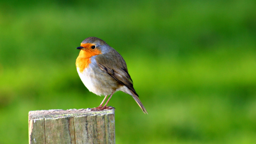

In [76]:
urls = search_images('a bird in forest photo', max_images=3)
dest = 'a bird in forest.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

## Build image folders in bulk
Download two types of photos (bird, not bird) and mkdir folders

In [48]:
keywords = 'bird','forest'
path = Path('bird or not')

for o in keywords:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)

verify all downloaded images (if not success, delete it)

In [50]:
for o in keywords:
    dest = path/o
    failed = verify_images(get_image_files(dest))
    failed.map(Path.unlink)
    print(len(failed))

0
0


## Put images into dataloader

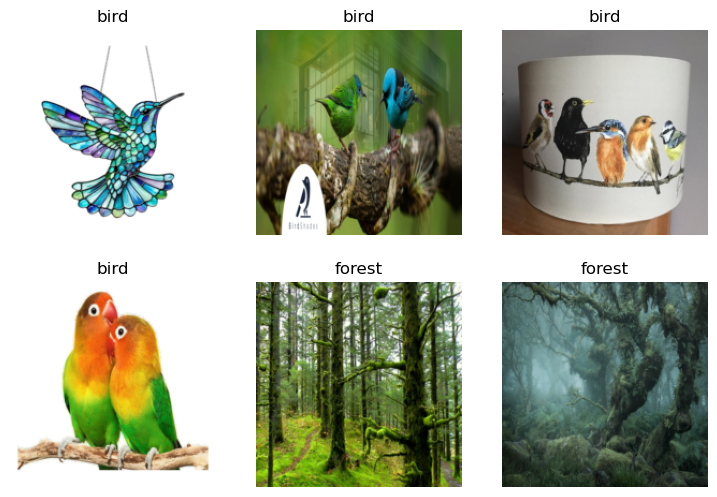

In [55]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items= get_image_files,
    splitter= RandomSplitter(valid_pct=0.2, seed=1),
    get_y = parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)
dls.show_batch(max_n=6)

dataloader is ready, now train it with **vision_learner** + resnet18
## Train a vision_learner

In [63]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

### fine_tune
- 本质上相当于：
  
1. learn.fit_one_cycle(1)  # 第一步：冻结基础层，训练新分类层
1. learn.unfreeze()        # 解冻所有层，允许完整训练
1. learn.fit_one_cycle(3)  # 第二步：整体微调模型，训练所有层

In [64]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.722130,0.268966,0.095960,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.246596,0.226249,0.085859,00:27
1,0.157145,0.249679,0.070707,00:26
2,0.098951,0.227475,0.065657,00:26


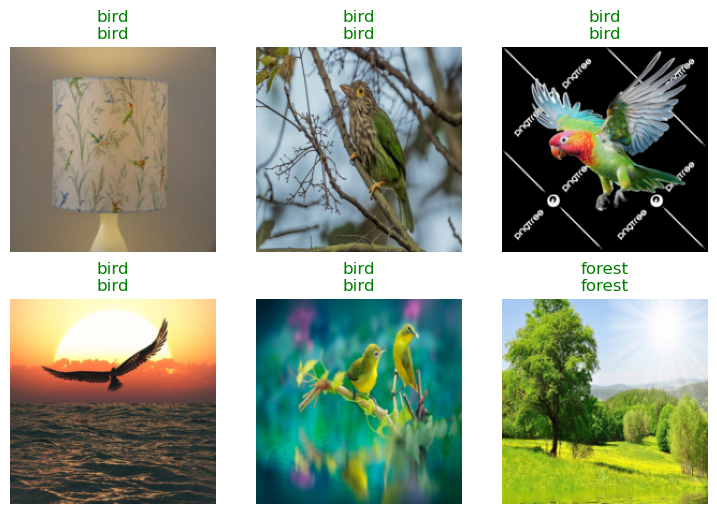

In [71]:
learn.show_results(max_n=6)

## Prediction
looks good! now predict a new one:
- why 使用fastai封装的PILImage.create()方法??

相当于：

```python
from PIL import Image

img = Image.open('bird.jpg')

# 但在fastai中使用时可能需要额外处理：
img = img.convert('RGB')  # 确保RGB模式
img = PILImage(img)       # 还需手动转为fastai的PILImage对象

```

In [73]:
learn.predict??

Signature: learn.predict(item, rm_type_tfms=None, with_input=False)
Docstring: Prediction on `item`, fully decoded, loss function decoded and probabilities
Source:   
    def predict(self, item, rm_type_tfms=None, with_input=False):
        dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
        inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
        i = getattr(self.dls, 'n_inp', -1)
        inp = (inp,) if i==1 else tuplify(inp)
        dec = self.dls.decode_batch(inp + tuplify(dec_preds))[0]
        dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
        res = dec_targ,dec_preds[0],preds[0]
        if with_input: res = (dec_inp,) + res
        return res
File:      ~/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/learner.py
Type:      method

In [85]:
is_bird,_, prob = learn.predict('a bird in forest.jpg')
print(f'What it the prediction: {is_bird}')
print(f'The probability of bird is: {prob[0]:.3f}')

What it the prediction: bird
The probability of bird is: 1.000
